In [1]:
cd /scratch/tsany/clim711/gfdl_spectral_code/t85barotropic

/scratch/tsany/clim711/gfdl_spectral_code/t85barotropic


In [2]:
ls

00000000.logfile.000000.out  barotropic.x*   eddy_change_2/  eddy_change_7/
00000000.time_stamp.out      data_table      eddy_change_3/  eddy_change_8/
INPUT/                       diag_table      eddy_change_4/  input.nml
RESTART/                     eddy_change_0/  eddy_change_5/  rr.png
barotropic.nc                eddy_change_1/  eddy_change_6/


In [3]:
# eddy_change_1 = 0.0
# eddy_change_2 = 5.0
# eddy_change_3 = 10.0
# default = 15.0
# eddy_change_4 = 20.0
# eddy_change_5 = 25.0
# eddy_change_0 = 30.0;
# Eddy_change_6 = 40.0

# Eddy_change_7 = 60.0
# eddy_change_8 = 90.0
# 9==default

`Question:` How does the latitude width of the initial vorticity disturbance ('eddy_width') in the barotropic atmosphere model influence the lifecycle and propagation characteristics of the Rossby waves?

`Hypothesis:` In the barotropic model, the Eddy Width plays a crucial role in determining the behavior of Rossby waves. A wider 'eddy_width' results in Rossby waves that have a longer lifespan and will move slowly. In contrast, narrower disturbances lead to shorter-lived and faster-moving Rossby waves. 

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.util import add_cyclic_point
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

In [5]:
eddy_changes = {}

for i in range(9):
    path = f'/scratch/tsany/clim711/gfdl_spectral_code/t85barotropic/eddy_change_{i}/'
    eddy_changes[f'eddy_change_{i}'] = xr.open_dataset(f'{path}barotropic.nc', decode_times=False)


In [6]:
# Reorganize 
ds_0 = eddy_changes['eddy_change_1']
ds_5 = eddy_changes['eddy_change_2']
ds_10 = eddy_changes['eddy_change_3']
ds_15 = xr.open_dataset('/scratch/tsany/clim711/gfdl_spectral_code/t85barotropic/barotropic.nc', decode_times=False)
ds_20 = eddy_changes['eddy_change_4']
ds_25 = eddy_changes['eddy_change_5']
ds_30 = eddy_changes['eddy_change_0']
ds_40 = eddy_changes['eddy_change_6']

ds_60 = eddy_changes['eddy_change_7']
ds_90 = eddy_changes['eddy_change_8']

In [7]:
# Reorganize
ds_20

<xarray.Dataset>
Dimensions:   (lon: 256, lonb: 257, lat: 128, latb: 129, time: 25)
Coordinates:
  * lon       (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lonb      (lonb) float64 -0.7031 0.7031 2.109 3.516 ... 356.5 357.9 359.3
  * lat       (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * latb      (latb) float64 -90.0 -88.28 -86.87 -85.46 ... 86.87 88.28 90.0
  * time      (time) float64 1.0 2.0 3.0 4.0 5.0 ... 21.0 22.0 23.0 24.0 25.0
Data variables:
    ucomp     (time, lat, lon) float32 ...
    vcomp     (time, lat, lon) float32 ...
    vor       (time, lat, lon) float32 ...
    pv        (time, lat, lon) float32 ...
    stream    (time, lat, lon) float32 ...
    trs       (time, lat, lon) float32 ...
    tr        (time, lat, lon) float32 ...
    eddy_vor  (time, lat, lon) float32 ...
    delta_u   (time, lat, lon) float32 ...
Attributes:
    filename:   barotropic.nc
    title:      t85barotropic
    grid_type:  regular
    grid_tile:  N/A

In [8]:
# List of your datasets
datasets = [ds_0, ds_5, ds_10, ds_15, ds_20, ds_25, ds_30, ds_40]
eddy_widths = ['0', '5', '10', '15', '20', '25', '30', '40']

# Calculate the maximum absolute value across all datasets for symmetry
max_abs_value = max([max(abs(ds['vor'].min()), abs(ds['vor'].max())) for ds in datasets])

# Set vmin and vmax for a symmetrical colorbar around zero
vmin, vmax = -max_abs_value, max_abs_value
print(vmin.values, vmax.values)

-5.102340946905315e-05 5.102340946905315e-05


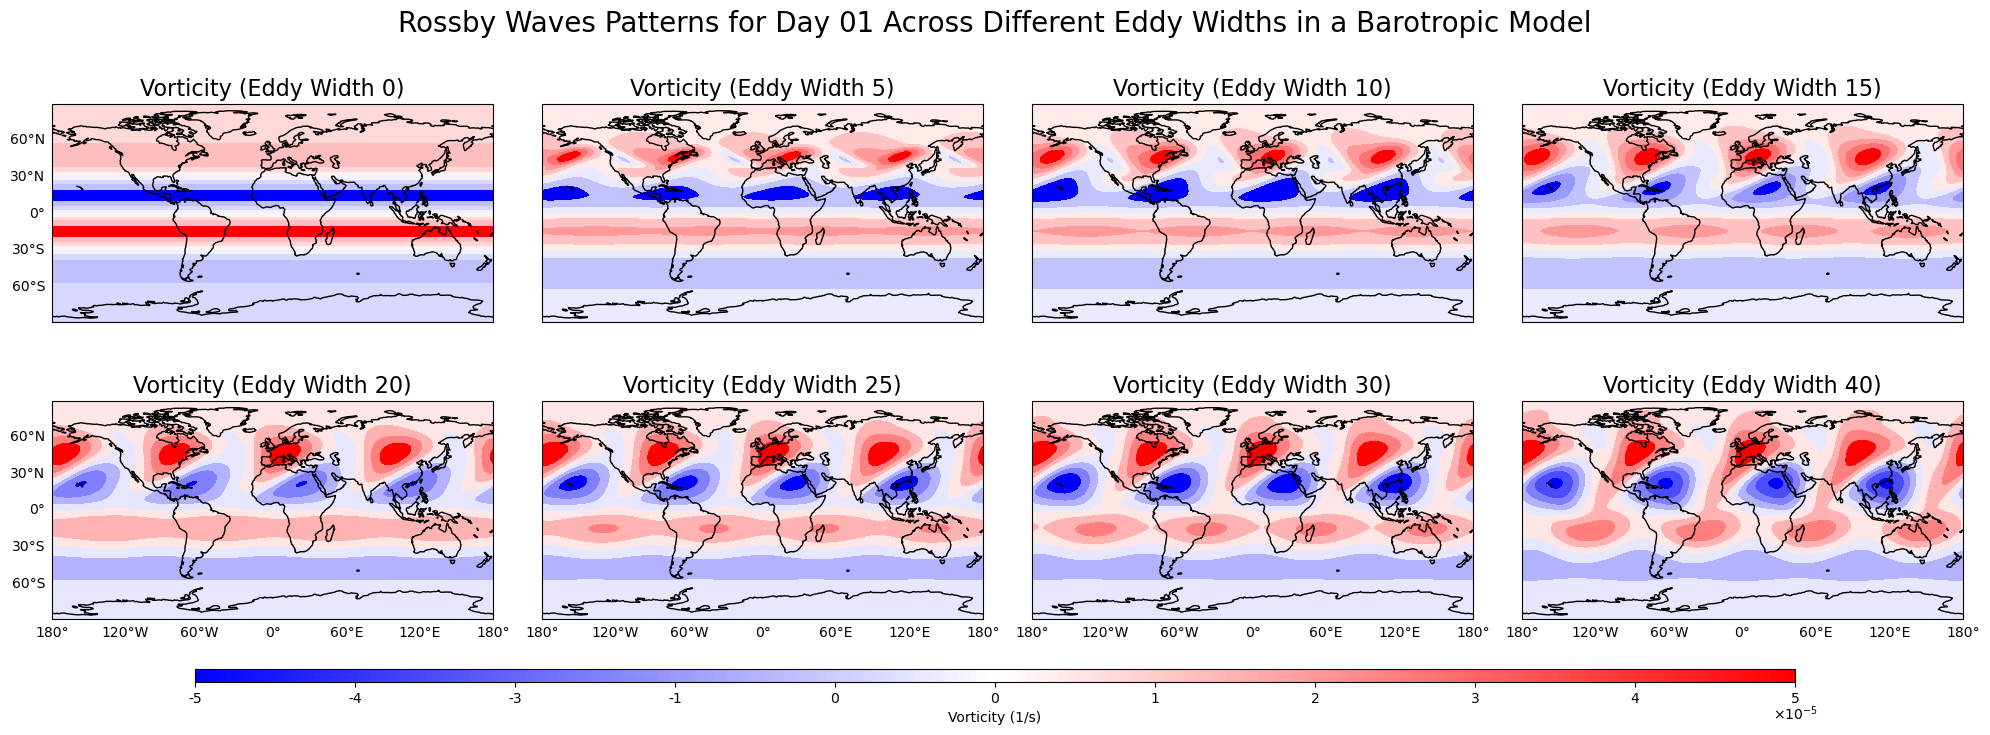

In [9]:
# Day 01 -- time = 0
# Manually setting our vmin and vmax for a symmetrical colorbar around zero
vmin, vmax = -5e-5, 5e-5
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 6.4), subplot_kw={'projection': ccrs.PlateCarree()})

axes = axes.flatten()

for i, ds in enumerate(datasets):
    data, lons = add_cyclic_point(ds['vor'].isel(time=0), coord=ds['lon'])
    pcm = axes[i].contourf(lons, ds['lat'], data, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap='bwr', extend='both')
    axes[i].add_feature(cf.COASTLINE)
    axes[i].set_title(f'Vorticity (Eddy Width {eddy_widths[i]})', fontsize=16)

    # Gridlines
    gl = axes[i].gridlines(draw_labels=True, linewidth=0)
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = i >= 4  
    gl.left_labels = i % 4 == 0  

# Adjust the layout
plt.tight_layout()

# Create a ScalarMappable with the normalization and colormap for the colorbar
norm = Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(norm=norm, cmap='bwr')

# Add a single colorbar for all subplots
cbar_ax = fig.add_axes([0.1, 0.0, 0.8, 0.02])  # x-position, y-position, width, height
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', label='Vorticity (1/s)')

# Define the tick locations and labels
ticks = np.linspace(vmin, vmax, 11)
tick_labels = [f'{int(tick/1e-5)}' for tick in ticks]

# Set the ticks and labels on the colorbar
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)
cbar.ax.text(1, -2.5, r'$\times 10^{-5}$', ha='center', va='center', transform=cbar.ax.transAxes)


plt.suptitle('Rossby Waves Patterns for Day 01 Across Different Eddy Widths in a Barotropic Model', fontsize=20, y=1.05)

# Show the plot
plt.show()

In [10]:
def plot_vorticity_for_time_step(time_step):
    # Constants for the colorbar
    vmin, vmax = -5e-5, 5e-5
    eddy_widths = ['0', '5', '10', '15', '20', '25', '30', '40']
    
    # Set up the figure and axes
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 6.4), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()
    
    # Plot each dataset
    for i, ds in enumerate(datasets):
        data, lons = add_cyclic_point(ds['vor'].isel(time=time_step), coord=ds['lon'])
        pcm = axes[i].contourf(lons, ds['lat'], data, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap='bwr', extend='both')
        axes[i].add_feature(cf.COASTLINE)
        axes[i].set_title(f'Vorticity (Eddy Width {eddy_widths[i]})', fontsize=16)

        # Gridlines
        gl = axes[i].gridlines(draw_labels=True, linewidth=0)
        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels = i >= 4  
        gl.left_labels = i % 4 == 0  

    # Adjust the layout
    plt.tight_layout()

    # Create a ScalarMappable with the normalization and colormap for the colorbar
    norm = Normalize(vmin=vmin, vmax=vmax)
    sm = ScalarMappable(norm=norm, cmap='bwr')

    # Add a single colorbar for all subplots
    cbar_ax = fig.add_axes([0.1, 0.0, 0.8, 0.02])  # x-position, y-position, width, height
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', label='Vorticity (1/s)')

    # Define the tick locations and labels
    ticks = np.linspace(vmin, vmax, 11)
    tick_labels = [f'{int(tick/1e-5)}' for tick in ticks]

    # Set the ticks and labels on the colorbar
    cbar.set_ticks(ticks)
    cbar.set_ticklabels(tick_labels)
    cbar.ax.text(1, -2.5, r'$\times 10^{-5}$', ha='center', va='center', transform=cbar.ax.transAxes)

    # Add the super title for the entire figure
    # plt.suptitle(f'Rossby Waves Patterns for Day {time_step+1} Across Different Eddy Widths in a Barotropic Model', fontsize=20, y=1.05)
    # plt.savefig(f'/scratch/tsany/CLIM711/vor_Day{time_step+1}')
    # Show the plot
    plt.show()

# Example usage:
# plot_vorticity_for_time_step(24)  # For day 25, since Python is 0-indexed


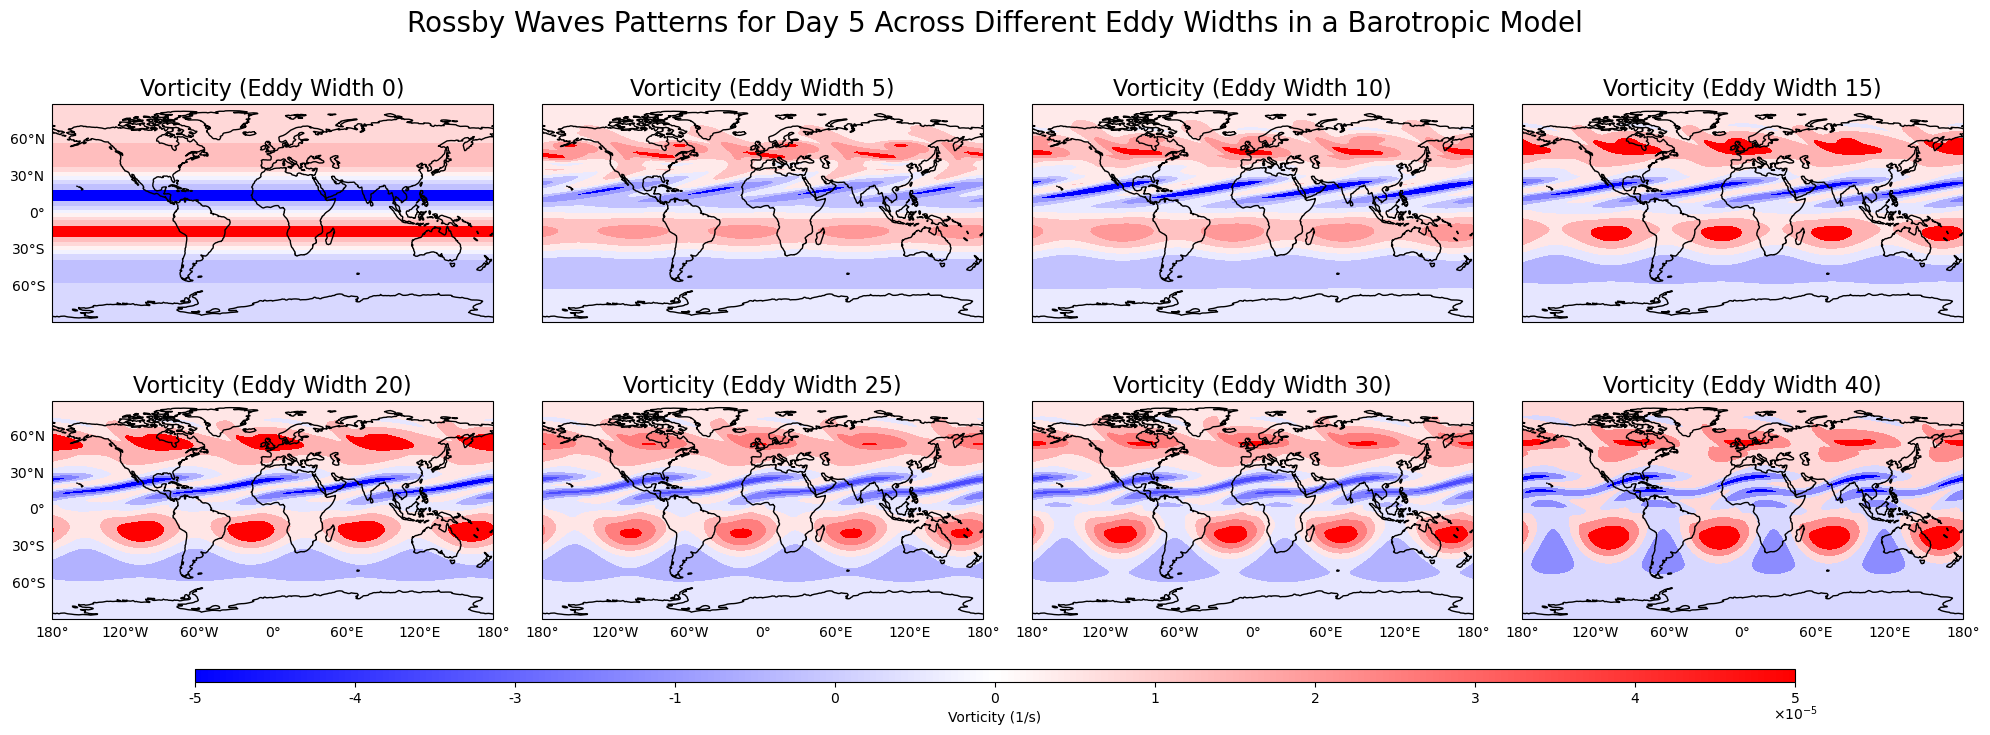

In [11]:
# Day 05 -- time = 4
plot_vorticity_for_time_step(4) 

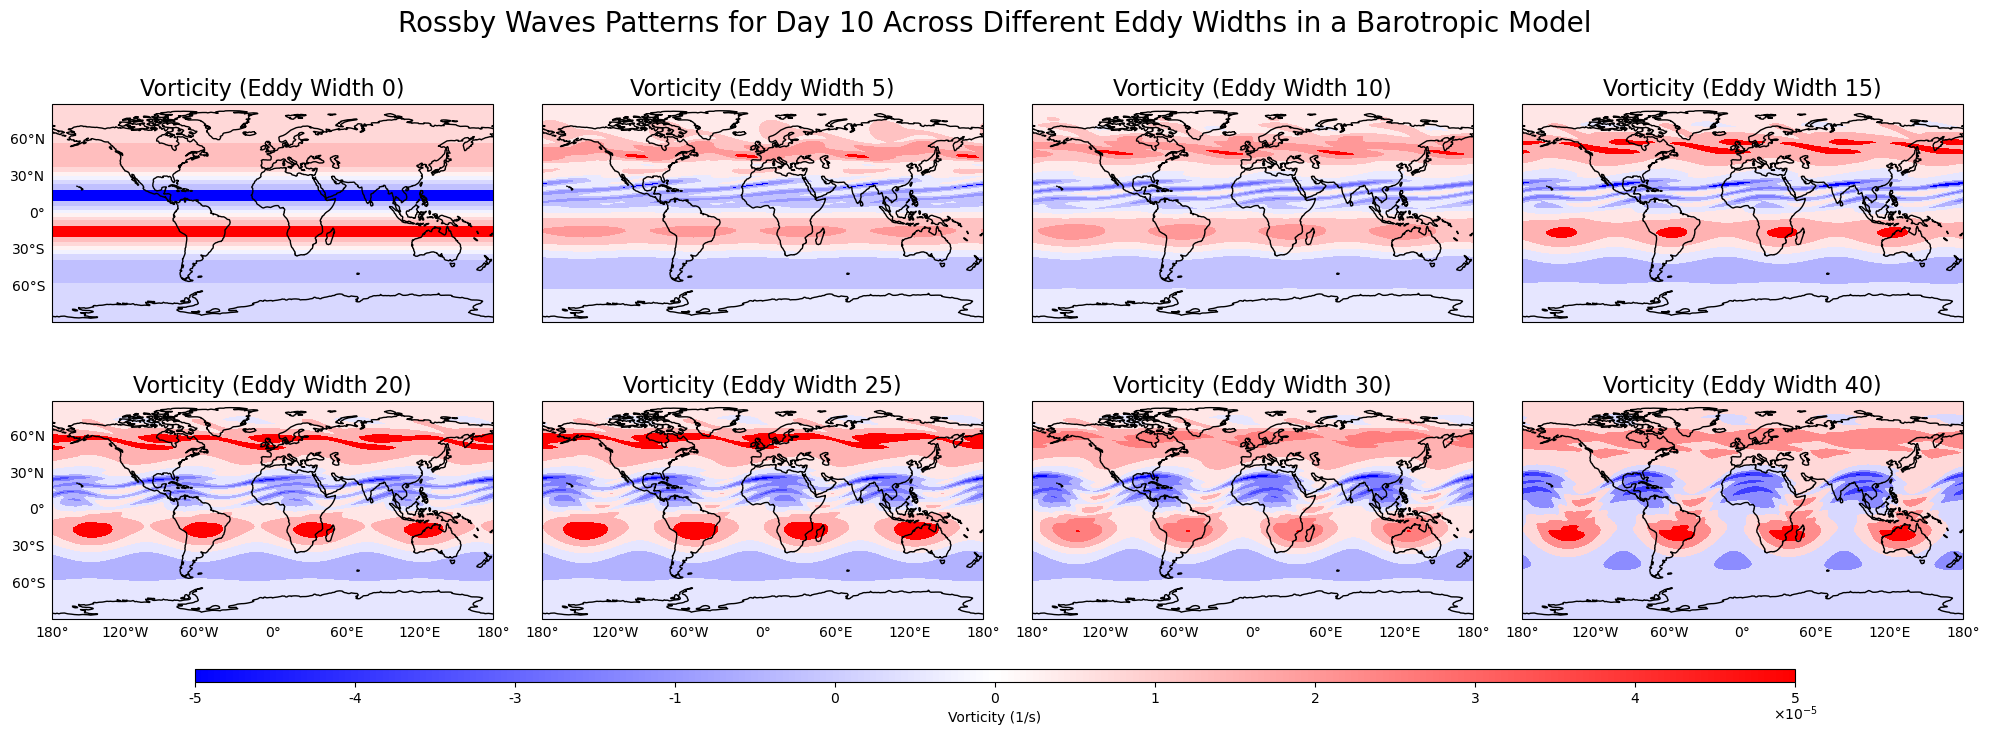

In [12]:
# Day 10 -- time = 9
plot_vorticity_for_time_step(9) 

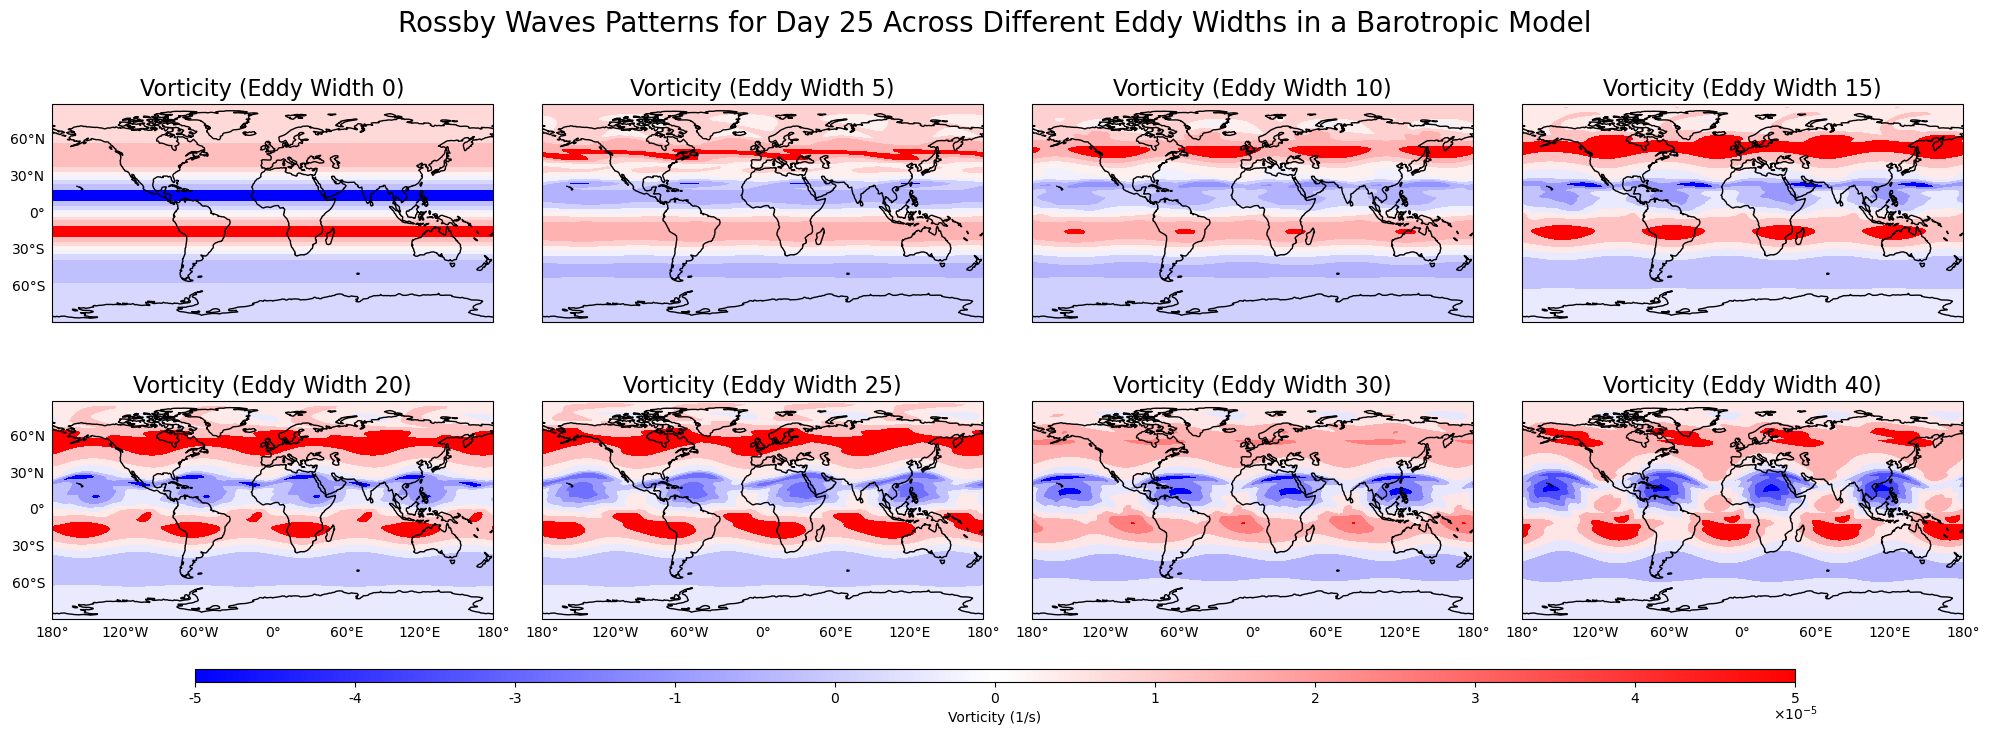

In [13]:
# Day 25 -- time = 24
plot_vorticity_for_time_step(24) 

In [14]:
# print(datasets.keys)

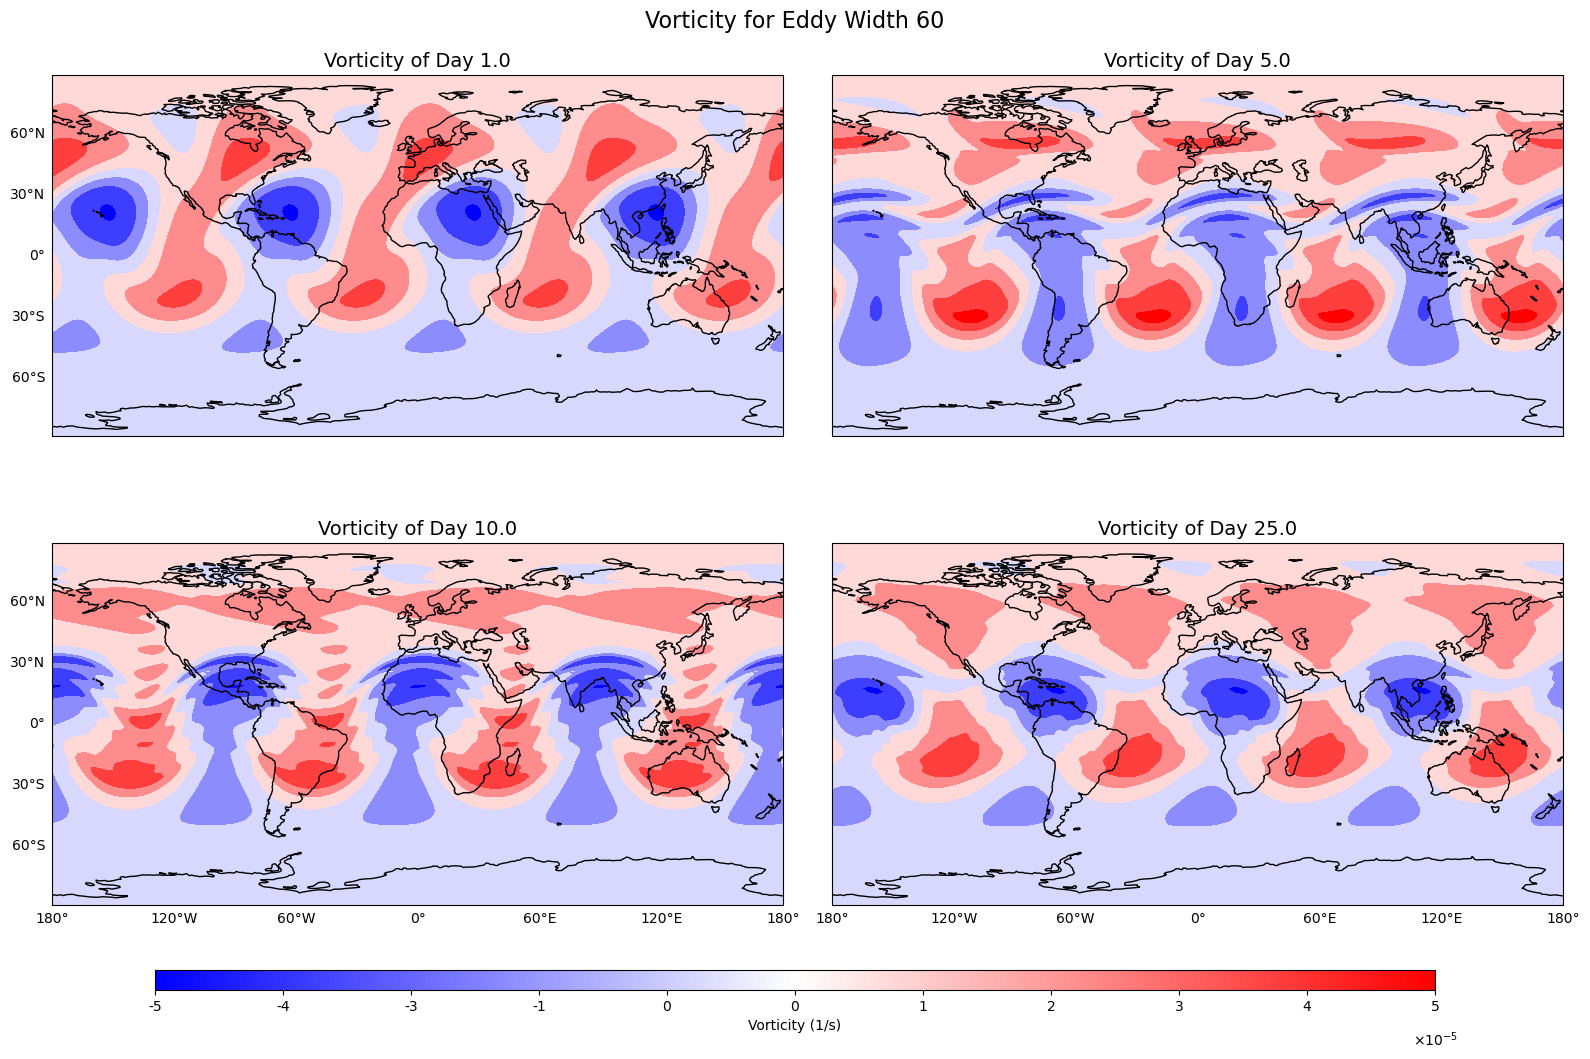

In [17]:

# Determine common colorbar limits
# vmin = ds.vor.min()
# vmax = ds.vor.max()
vmin, vmax = -5e-5, 5e-5

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10),
                         subplot_kw={'projection': ccrs.PlateCarree()})

# Flatten the axes array for easy iteration
axes = axes.flatten()

days = [1,5,10,25]
for i, ax in enumerate(axes):    
    data = ds_60.vor[days[i]-1,:,:]
    data, lons = add_cyclic_point(data, coord=data['lon'])
    pcm = ax.contourf(lons, ds.vor.lat, data, transform=ccrs.PlateCarree(),
                      vmin=vmin, vmax=vmax, cmap='bwr') 
    ax.add_feature(cf.COASTLINE)
    ax.set_title(f"Vorticity of Day {ds.vor[days[i]-1,:,:].time.values}", fontsize=14)
    
    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0)
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = i > 1  # Only label the bottom row 
    gl.left_labels = i % 2 == 0  # Only label the left-most column

# Adjust the layout
plt.tight_layout()

# Create a ScalarMappable with the normalization and colormap for the colorbar
norm = Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(norm=norm, cmap='bwr')

# Add a single colorbar for all subplots
cbar_ax = fig.add_axes([0.1, 0.0, 0.8, 0.02])  # x-position, y-position, width, height
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', label='Vorticity (1/s)')

# Define the tick locations and labels
ticks = np.linspace(vmin, vmax, 11)
tick_labels = [f'{int(tick/1e-5)}' for tick in ticks]

# Set the ticks and labels on the colorbar
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)
cbar.ax.text(1, -2.5, r'$\times 10^{-5}$', ha='center', va='center', transform=cbar.ax.transAxes)


plt.suptitle('Vorticity for Eddy Width 60', fontsize=16)
plt.show()

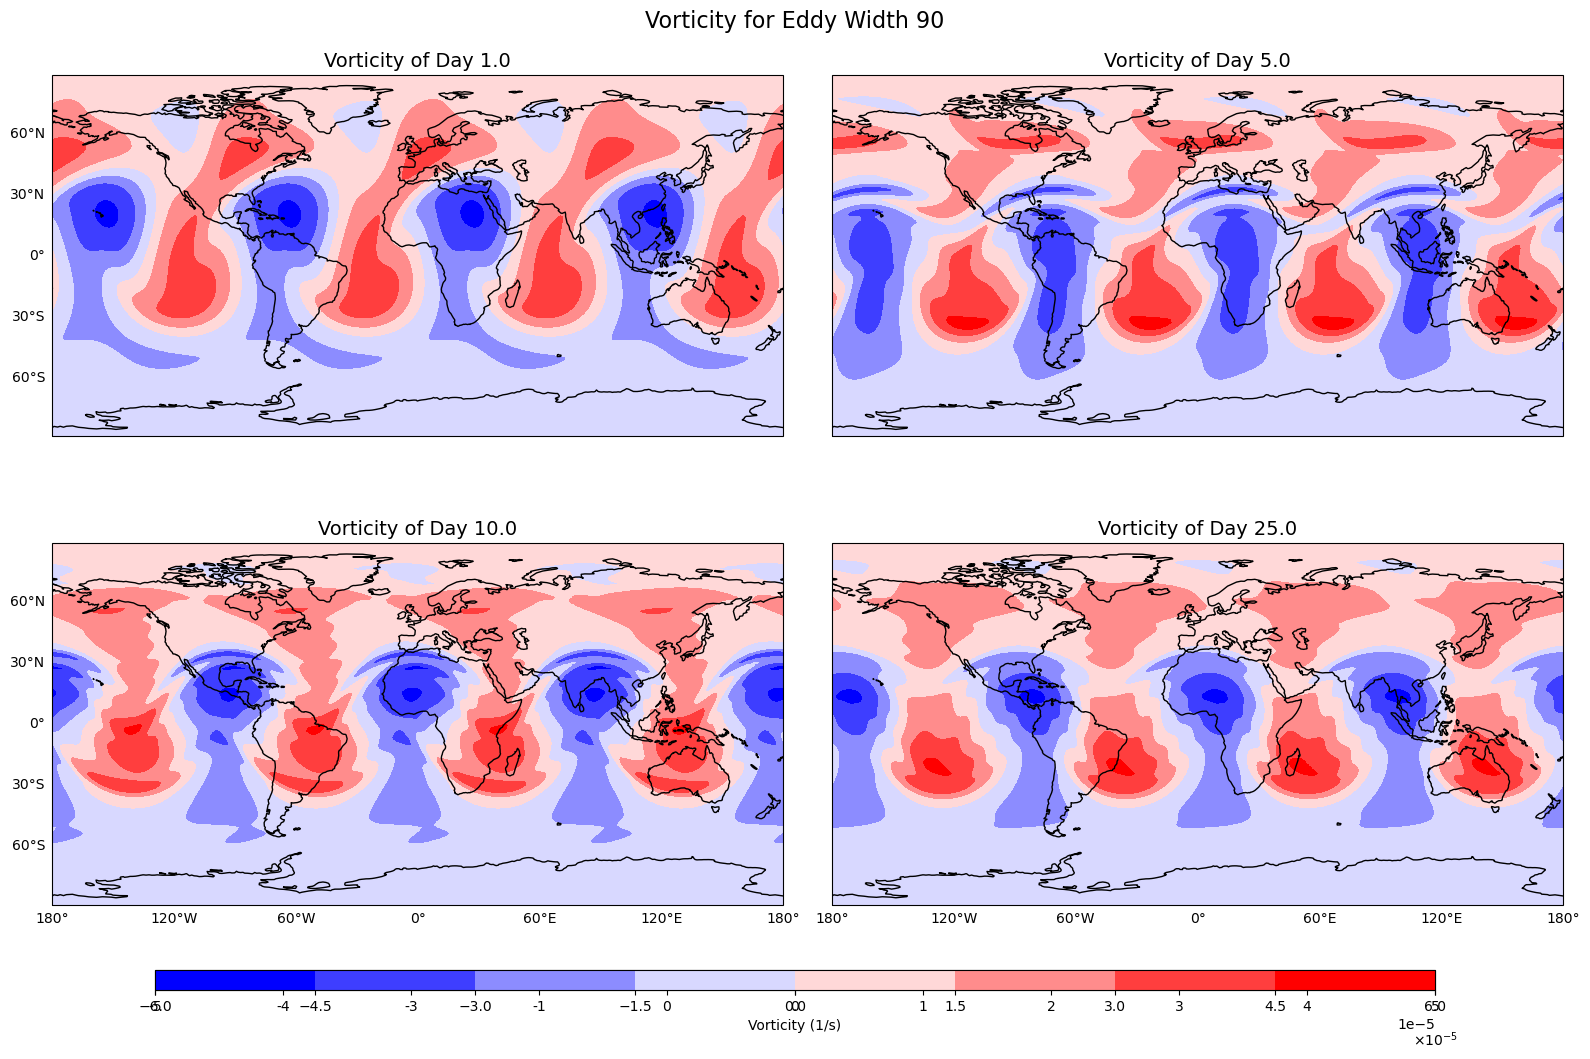

In [18]:

# Determine common colorbar limits
vmin, vmax = -5e-5, 5e-5
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10),
                         subplot_kw={'projection': ccrs.PlateCarree()})

# Flatten the axes array for easy iteration
axes = axes.flatten()

days = [1,5,10,25]
for i, ax in enumerate(axes):    
    data = ds_90.vor[days[i]-1,:,:]
    data, lons = add_cyclic_point(data, coord=data['lon'])
    pcm = ax.contourf(lons, ds.vor.lat, data, transform=ccrs.PlateCarree(),
                      vmin=vmin, vmax=vmax, cmap='bwr') 
    ax.add_feature(cf.COASTLINE)
    ax.set_title(f"Vorticity of Day {ds.vor[days[i]-1,:,:].time.values}", fontsize=14)
    
    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0)
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = i > 1  # Only label the bottom row 
    gl.left_labels = i % 2 == 0  # Only label the left-most column

# Adjust the layout
plt.tight_layout()

# Create a ScalarMappable with the normalization and colormap for the colorbar
norm = Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(norm=norm, cmap='bwr')

# Add a single colorbar for all subplots
cbar_ax = fig.add_axes([0.1, 0.0, 0.8, 0.02])  # x-position, y-position, width, height
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', label='Vorticity (1/s)')

# Define the tick locations and labels
ticks = np.linspace(vmin, vmax, 11)
tick_labels = [f'{int(tick/1e-5)}' for tick in ticks]

# Set the ticks and labels on the colorbar
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)
cbar.ax.text(1, -2.5, r'$\times 10^{-5}$', ha='center', va='center', transform=cbar.ax.transAxes)


# Add a single colorbar
cbar_ax = fig.add_axes([0.1, 0, 0.8, 0.02])  # x-position, y-position, width, height
fig.colorbar(pcm, cax=cbar_ax, orientation='horizontal')
plt.suptitle('Vorticity for Eddy Width 90', fontsize=16)
plt.show()

In [19]:
# Plot wind data
ds = ds_15 


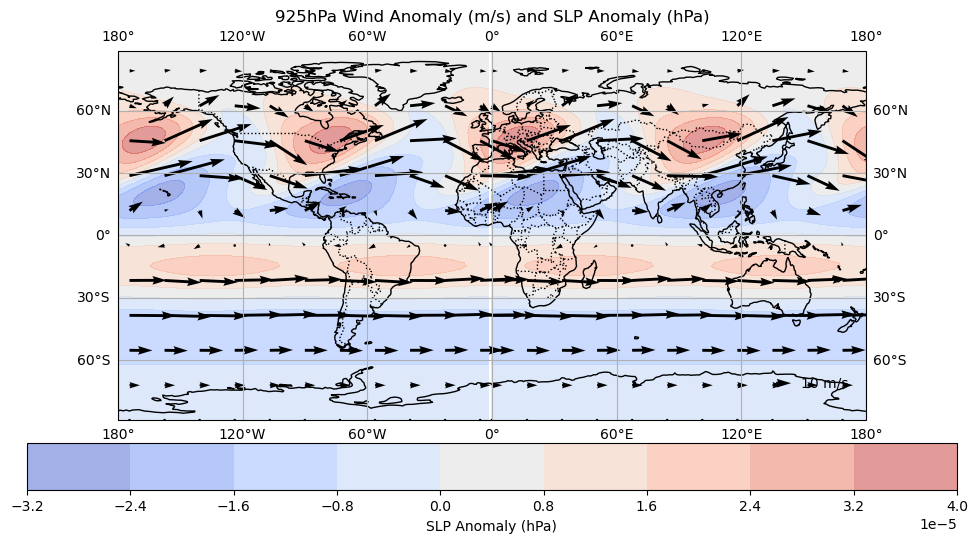

In [20]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import numpy as np
import xarray as xr

# Assuming 'ds' is your xarray Dataset with 'ucomp', 'vcomp', and another variable (e.g., 'slp_anom' for sea level pressure anomaly)
# Replace '...' with actual variable names and data
# ds = xr.open_dataset('path_to_your_dataset.nc')  # Replace with the path to your dataset

# Calculate wind speed
wind_speed = np.sqrt(ds['ucomp']**2 + ds['vcomp']**2)

# Select a specific time step
time_step = 0  # Replace with your actual time step index
u = ds['ucomp'].isel(time=time_step)
v = ds['vcomp'].isel(time=time_step)
slp_anom = ds['vor'].isel(time=time_step)  # Replace 'slp_anom' with your variable name

# Subsample the data to reduce the density of the quiver plot
stride = 12
u_sub = u[::stride, ::stride]
v_sub = v[::stride, ::stride]
lon_sub = ds['lon'][::stride]
lat_sub = ds['lat'][::stride]

# Create the map projection and figure
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': proj})
ax.coastlines()
ax.add_feature(cf.BORDERS, linestyle=':')

# Plot the scalar field using contourf
contour = ax.contourf(ds['lon'], ds['lat'], slp_anom, transform=proj, cmap='coolwarm', alpha=0.5)

# Add a colorbar for the contour
cbar = fig.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label('SLP Anomaly (hPa)')

# Plot the wind vectors using quiver
Q = ax.quiver(lon_sub, lat_sub, u_sub, v_sub, transform=proj, color='black', scale=500)

# Optionally, add a quiver key to show vector magnitude reference
qk = ax.quiverkey(Q, 0.9, 0.1, 10, '10 m/s', labelpos='E')

# Add gridlines
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Set plot title
plt.title('925hPa Wind Anomaly (m/s) and SLP Anomaly (hPa)')

# Show the plot
plt.show()


In [23]:
def plot_vorticity_for_time_step(time_step):
    # Constants for the colorbar
    vmin, vmax = -5e-5, 5e-5
    eddy_widths = ['0', '5', '10', '15', '20', '25', '30', '40']
    
    # Set up the figure and axes
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 6.4), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()
    
    # Plot each dataset
    for i, ds in enumerate(datasets):
        data = ds['vor'].isel(time=time_step)
        ucomp = ds['ucomp'].isel(time=time_step)
        vcomp = ds['vcomp'].isel(time=time_step)

        # Add cyclic points for continuity in the plot
        data_cyclic, lon_cyclic = add_cyclic_point(data, coord=ds['lon'])
        ucomp_cyclic, _ = add_cyclic_point(ucomp, coord=ds['lon'])
        vcomp_cyclic, _ = add_cyclic_point(vcomp, coord=ds['lon'])

        # Create meshgrid for quiver
        lon2d, lat2d = np.meshgrid(lon_cyclic, ds['lat'])
        
        # Subsample data for quiver to avoid overcrowding
        quiver_stride = 5
        lon2d_sub = lon2d[::quiver_stride, ::quiver_stride]
        lat2d_sub = lat2d[::quiver_stride, ::quiver_stride]
        ucomp_sub = ucomp_cyclic[::quiver_stride, ::quiver_stride]
        vcomp_sub = vcomp_cyclic[::quiver_stride, ::quiver_stride]

        # Plot the vorticity
        pcm = axes[i].contourf(lon_cyclic, ds['lat'], data_cyclic, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap='bwr', extend='both')
        axes[i].add_feature(cf.COASTLINE)
        axes[i].set_title(f'Vorticity (Eddy Width {eddy_widths[i]})', fontsize=16)
        
        # Quiver plot for wind vectors
        axes[i].quiver(lon2d_sub, lat2d_sub, ucomp_sub, vcomp_sub, transform=ccrs.PlateCarree(), color='black', scale=400)

        # Gridlines
        gl = axes[i].gridlines(draw_labels=True, linewidth=0)
        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels = i >= 4  
        gl.left_labels = i % 4 == 0  

    # Adjust the layout
    plt.tight_layout()

    # Create a ScalarMappable with the normalization and colormap for the colorbar
    norm = Normalize(vmin=vmin, vmax=vmax)
    sm = ScalarMappable(norm=norm, cmap='bwr')

    # Add a single colorbar for all subplots
    cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])  # x-position, y-position, width, height
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', label='Vorticity (1/s)')

    # Define the tick locations and labels
    ticks = np.linspace(vmin, vmax, 11)
    tick_labels = [f'{int(tick/1e-5)}' for tick in ticks]

    # Set the ticks and labels on the colorbar
    cbar.set_ticks(ticks)
    cbar.set_ticklabels(tick_labels)
    cbar.ax.text(1, -2.5, r'$\times 10^{-5}$', ha='center', va='center', transform=cbar.ax.transAxes)

    # Add the super title for the entire figure
    plt.suptitle(f'Rossby Waves Patterns for Day {time_step+1} Across Different Eddy Widths in a Barotropic Model', fontsize=20, y=1.05)

    # Show the plot
    plt.show()


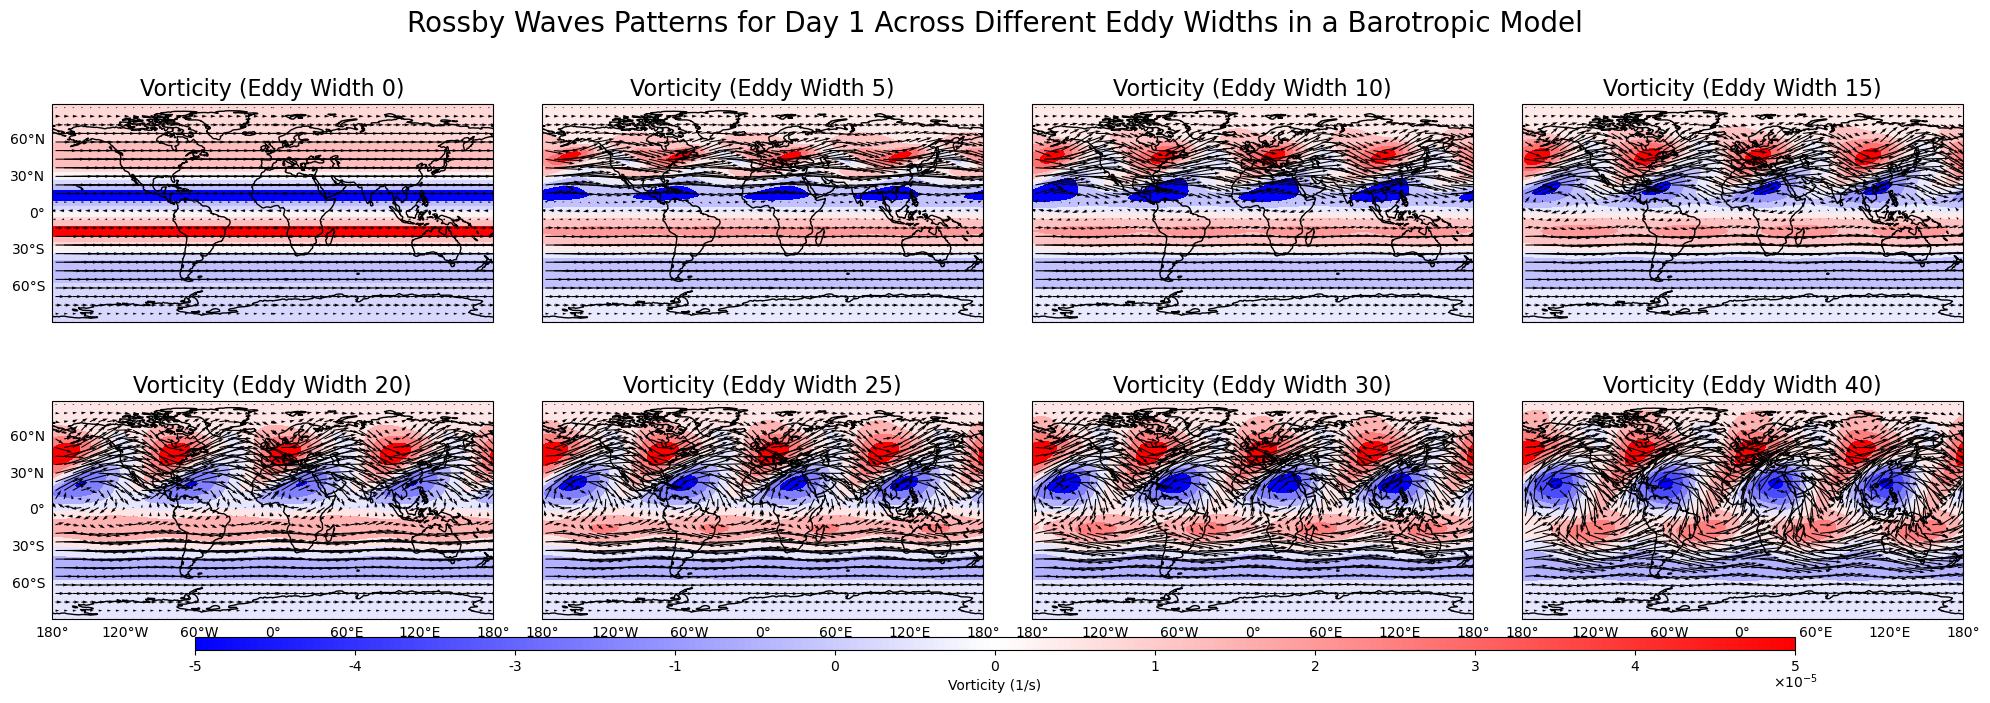

In [25]:
plot_vorticity_for_time_step(0)